In [34]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression, LogisticRegression

# Data Acquision

- SP500: https://finance.yahoo.com/quote/%5EGSPC/
- MY10Y: https://fred.stlouisfed.org/series/DGS10
- CPI: https://fred.stlouisfed.org/series/CPIAUCSL
- CSENT: https://fred.stlouisfed.org/series/UMCSENT
- IPM: https://fred.stlouisfed.org/series/IPMAN
- HOUSE: https://fred.stlouisfed.org/series/HSN1F
- UNEMP: https://fred.stlouisfed.org/series/UNRATE

In [35]:
"""
import yfinance as yf
from fredapi import Fred
from config import get_fredapi_key
# define fred api (using my personal api key)
fred = Fred(api_key = get_fredapi_key())


# Generate a date range from January 1950 to the present
date_range = date_range = pd.date_range(start='1950', end='2024', freq='M')

# Create Original data frame, wich Date, Year, Month columns
df_origin = pd.DataFrame({'Date': date_range})
df_origin['Year'] = df_origin['Date'].dt.year
df_origin['Month'] = df_origin['Date'].dt.month


### Data from Fred
# list of ids and column names of monthly data
ids = ['DGS10', 'CPIAUCSL', 'UMCSENT', 'IPMAN', 'HSN1F', 'UNRATE']
cols = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

# travering all pairs of ids and cols
for id, col in zip(ids, cols):
    # get the original data
    original = fred.get_series(id)
    # convert current index to column & change monthly data
    df_merge = original.resample('M').last().reset_index()
    # change column names
    df_merge.columns = ['Date', col]

    # merge two data frames
    df_origin = pd.merge(df_origin, df_merge, on='Date', how='left')


# Download S&P500 data as ticker "^GSPC" and convert to monthly data
sp500 = yf.download(['^GSPC'], start='1950-01-01').resample('M').last().reset_index()
# Add the close prices of S&P500 on each month
df_origin['SP500'] = sp500[sp500['Date'] >= '1950-01-31']['Close']

# download the original dataframe as csv
df_origin.to_csv('original.csv', index=False)

# show the first 5 rows
df_origin.head()

"""

'\nimport yfinance as yf\nfrom fredapi import Fred\nfrom config import get_fredapi_key\n# define fred api (using my personal api key)\nfred = Fred(api_key = get_fredapi_key())\n\n\n# Generate a date range from January 1950 to the present\ndate_range = date_range = pd.date_range(start=\'1950\', end=\'2024\', freq=\'M\')\n\n# Create Original data frame, wich Date, Year, Month columns\ndf_origin = pd.DataFrame({\'Date\': date_range})\ndf_origin[\'Year\'] = df_origin[\'Date\'].dt.year\ndf_origin[\'Month\'] = df_origin[\'Date\'].dt.month\n\n\n### Data from Fred\n# list of ids and column names of monthly data\nids = [\'DGS10\', \'CPIAUCSL\', \'UMCSENT\', \'IPMAN\', \'HSN1F\', \'UNRATE\']\ncols = [\'MY10Y\', \'CPI\', \'CSENT\', \'IPM\', \'HOUSE\', \'UNEMP\']\n\n# travering all pairs of ids and cols\nfor id, col in zip(ids, cols):\n    # get the original data\n    original = fred.get_series(id)\n    # convert current index to column & change monthly data\n    df_merge = original.resample(\'M\'

In [36]:
# get original data from local file
df_origin = pd.read_csv('original.csv')
df_origin.tail()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
883,2023-08-31,2023,8,4.09,306.269,69.4,100.0659,662.0,3.8,4507.660156
884,2023-09-30,2023,9,4.59,307.481,67.9,100.2539,719.0,3.8,4288.049805
885,2023-10-31,2023,10,4.88,307.619,63.8,99.5531,679.0,3.9,4193.799805
886,2023-11-30,2023,11,4.39,NaN,NaN,NaN,NaN,NaN,4576.020020
887,2023-12-31,2023,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Clearning & Modification

In [37]:
# dropping rows based on any missing data
df = df_origin.dropna()

df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
265,1972-02-29,1972,2,6.04,41.4,92.8,36.2194,711.0,5.7,106.570000
268,1972-05-31,1972,5,6.05,41.6,88.6,36.9454,677.0,5.7,109.529999
271,1972-08-31,1972,8,6.42,41.9,95.2,37.5429,773.0,5.6,111.089996
274,1972-11-30,1972,11,6.28,42.4,90.7,38.8702,735.0,5.3,116.669998
277,1973-02-28,1973,2,6.64,43.0,81.9,40.3702,737.0,5.0,111.680000


Text(0.5, 1.0, 'Number of Data on Each Year.')

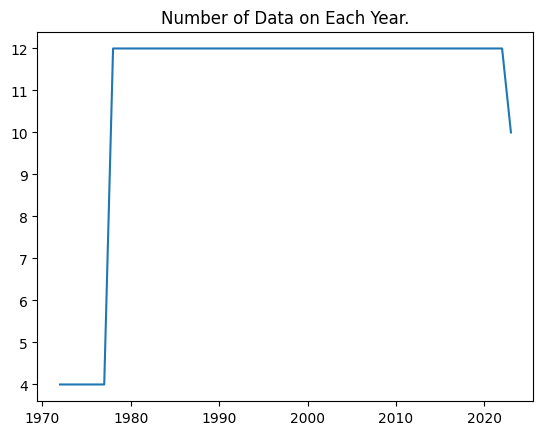

In [38]:
# groupby dataframe based on "Year" and check the count
group_year = df.groupby('Year').count()[['Date']]
plt.plot(group_year.index, group_year.values.flatten())
plt.title('Number of Data on Each Year.')

In [39]:
# Based on the observation, the data between 1973 and 1977 has missing in some months.
# Thus, removing data between 1973 and 1977.
df = df[df['Year'] >= 1978].reset_index(drop=True)
df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1978-01-31,1978,1,7.94,62.7,83.7,43.7471,795.0,6.4,89.250000
1,1978-02-28,1978,2,8.04,63.0,84.3,43.9139,791.0,6.3,87.040001
2,1978-03-31,1978,3,8.15,63.4,78.8,44.6899,814.0,6.3,89.209999
3,1978-04-30,1978,4,8.24,63.9,81.6,45.3905,864.0,6.1,96.830002
4,1978-05-31,1978,5,8.42,64.5,82.9,45.6235,857.0,6.0,97.239998


In [40]:
# copy the current SP500 as SP500_Price
df['SP500_Price'] = df['SP500'].loc[:]

# Create categorical data;
#  whether the S&P500 rises (1) or falls(0) from the previous year
cat_values = (df['SP500_Price'] > df['SP500_Price'].shift(12)).astype(int)
cat_values[:12] = None
df['SP500_Rise'] = cat_values

# Changes to %YoY
chg_YoY = ['CPI', 'CSENT', 'IPM', 'HOUSE', 'SP500']
df.loc[:, chg_YoY] = df[chg_YoY].pct_change(12) * 100

# drop the rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500,SP500_Price,SP500_Rise
0,1979-01-31,1979,1,8.95,9.250399,-13.859020,7.862464,-5.157233,5.9,11.966387,99.930000,1.0
1,1979-02-28,1979,2,9.17,9.841270,-12.336892,7.786828,-8.596713,5.9,10.615806,96.279999,1.0
2,1979-03-31,1979,3,9.11,10.252366,-13.197970,6.418676,-2.579853,5.8,13.877365,101.589996,1.0
3,1979-04-30,1979,4,9.35,10.485133,-19.117647,2.997984,-13.425926,5.8,5.091398,101.760002,1.0
4,1979-05-31,1979,5,9.06,10.697674,-17.852835,3.917937,-15.169195,5.6,1.892230,99.080002,1.0


In [41]:
# comparisons between original and cleaned data
print('Dimensions:')
print(df_origin.shape, ' -> ', df.shape)
print('')
print('Total Missing Valies:')
print(df_origin.isna().sum().sum(), ' -> ', df.isna().sum().sum())

Dimensions:
(888, 10)  ->  (538, 12)

Total Missing Valies:
820  ->  0


In [42]:
# basic statistics (original)
features = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP', 'SP500']
df_origin[features].describe()

,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
count,743.000000,886.000000,642.000000,622.000000,730.000000,886.000000,887.000000
mean,5.872759,122.482098,85.549688,74.287014,655.771233,5.731603,781.078714
std,2.990855,83.914413,12.899156,23.722896,208.186081,1.711548,1041.129126
min,0.550000,23.510000,50.000000,35.254500,270.000000,2.500000,17.049999
25%,3.855000,34.750000,76.025000,50.395325,515.000000,4.400000,88.895000
50%,5.620000,110.600000,89.200000,82.272800,628.500000,5.500000,249.220001
75%,7.630000,193.675000,94.975000,98.345950,765.000000,6.800000,1215.405029
max,15.840000,307.619000,112.000000,106.420200,1389.000000,14.700000,4766.180176


In [43]:
# basic statistics (current)
df[features].describe()

,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,5.769591,3.521535,0.436273,1.879105,1.551672,6.110409,10.051391
std,3.386562,2.755466,13.486383,4.901427,19.954754,1.782045,15.899805
min,0.550000,-1.958761,-41.520468,-19.513084,-50.534759,3.400000,-44.756241
25%,2.942500,1.901664,-6.547973,-0.287418,-10.868578,4.800000,2.071541
50%,5.070000,2.844395,0.299743,2.346995,2.734806,5.700000,11.647982
75%,7.997500,4.129159,6.687060,4.720490,13.591408,7.200000,19.604311
max,15.840000,14.592275,47.582205,20.819818,88.200590,14.700000,53.714506


# Data Observation

### Correlation Matrix

In [44]:
# correlation Matrix
df[features].corr()

,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
MY10Y,1.000000,0.592226,0.131251,0.159912,-0.106573,0.281409,0.040220
CPI,0.592226,1.000000,-0.229705,0.023940,-0.362021,0.008407,-0.019945
CSENT,0.131251,-0.229705,1.000000,0.297866,0.404014,0.173442,0.419360
IPM,0.159912,0.023940,0.297866,1.000000,0.133360,-0.235078,0.397629
HOUSE,-0.106573,-0.362021,0.404014,0.133360,1.000000,0.137665,0.378720
UNEMP,0.281409,0.008407,0.173442,-0.235078,0.137665,1.000000,0.025050
SP500,0.040220,-0.019945,0.419360,0.397629,0.378720,0.025050,1.000000


### Feature Reduction

In [45]:
# create a new feature and insert it 
df.insert(loc=9, column='LRIR', value=df['MY10Y'] - df['CPI'])

# drop MY10Y and CPI
df.drop(['MY10Y', 'CPI'], axis=1, inplace=True)

# show new dimension
print("New Dimension: ", df.shape)

# show new correlation matrix
features = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR', 'SP500']
df[features].corr()

New Dimension:  (538, 11)


,CSENT,IPM,HOUSE,UNEMP,LRIR,SP500
CSENT,1.000000,0.297866,0.404014,0.173442,0.380726,0.419360
IPM,0.297866,1.000000,0.133360,-0.235078,0.168055,0.397629
HOUSE,0.404014,0.133360,1.000000,0.137665,0.224958,0.378720
UNEMP,0.173442,-0.235078,0.137665,1.000000,0.328573,0.025050
LRIR,0.380726,0.168055,0.224958,0.328573,1.000000,0.067550
SP500,0.419360,0.397629,0.378720,0.025050,0.067550,1.000000


### Skewness

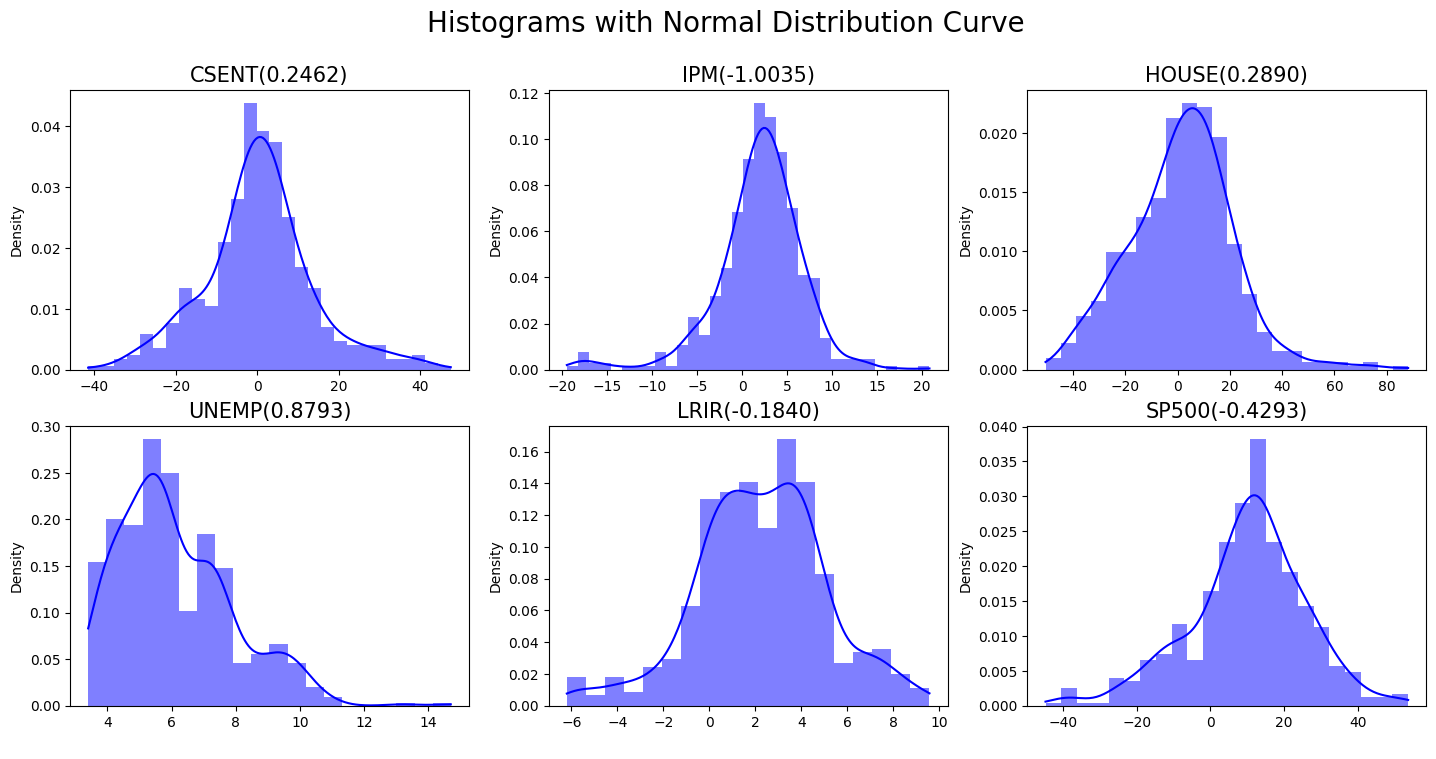

In [46]:
# plotting histograms
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(17.5, 8))
fig.suptitle('Histograms with Normal Distribution Curve', size=20)

for i, f in enumerate(features):
    r, c = divmod(i, 3)
    sns.histplot((df[f]), kde=True, color="blue", stat="density", linewidth=0, ax=ax[r][c])
    ax[r][c].set_title(f"{f}({skew(df[f]):.4f})", size=15)
    ax[r][c].set_xlabel(' ')

Text(0.5, 0, ' ')

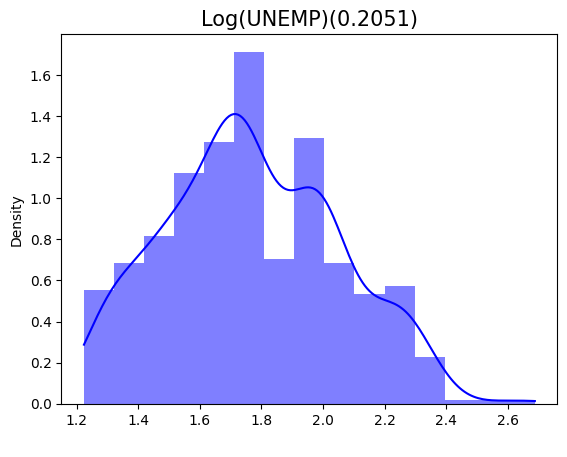

In [47]:
# change the "UNEMP" to log scale
df['UNEMP'] = np.log(df['UNEMP'])

# plotting the histogram again
sns.histplot(df['UNEMP'], kde=True, color="blue", stat="density", linewidth=0)
plt.title(f"Log(UNEMP)({skew(df['UNEMP']):.4f})", size=15)
plt.xlabel(' ')

In [15]:
# load the final data frame
#df.to_csv('final.csv', index=False)

### Correlation Plots

C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


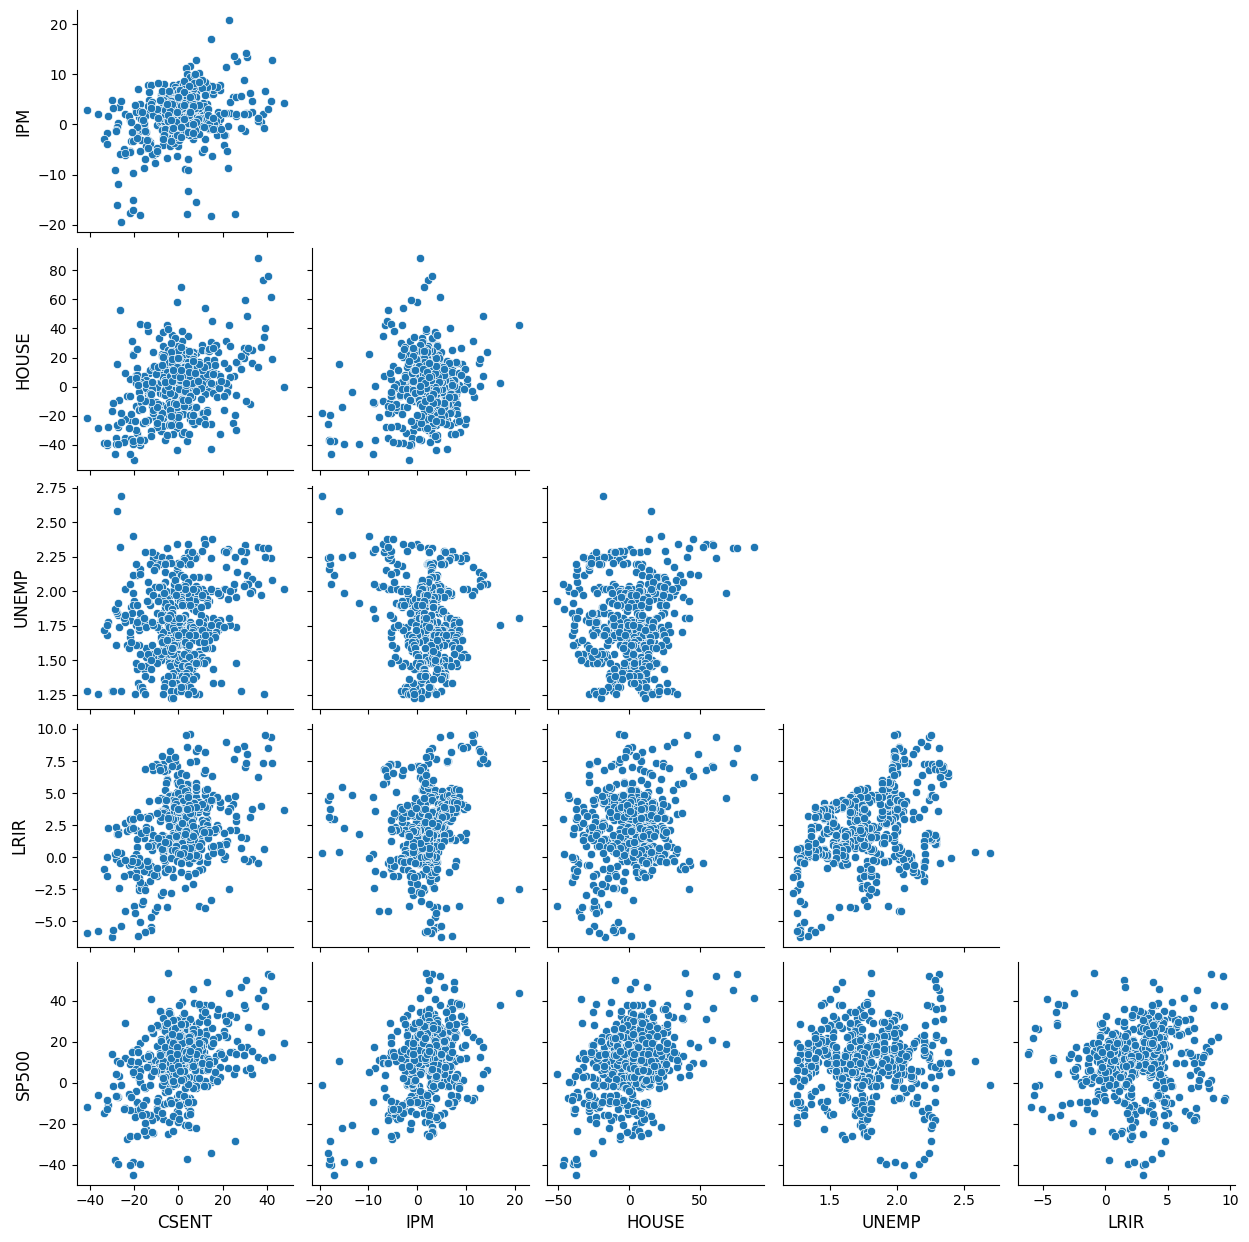

In [18]:
corr_plot = sns.pairplot(df[features], diag_kind=None)

for i in range(len(features)):
    for j in range(len(features)):
        if i <= j:  # This condition identifies upper triangle and diagonal plots
            corr_plot.axes[i, j].set_visible(False)

# Iterate again to set axis label font sizes (only for visible plots)
for ax in corr_plot.axes.flatten():
    if ax.get_visible():
        # Set x-axis label
        ax.set_xlabel(ax.get_xlabel(), fontsize='large')
        # Set y-axis label
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')

plt.show()

### Trend

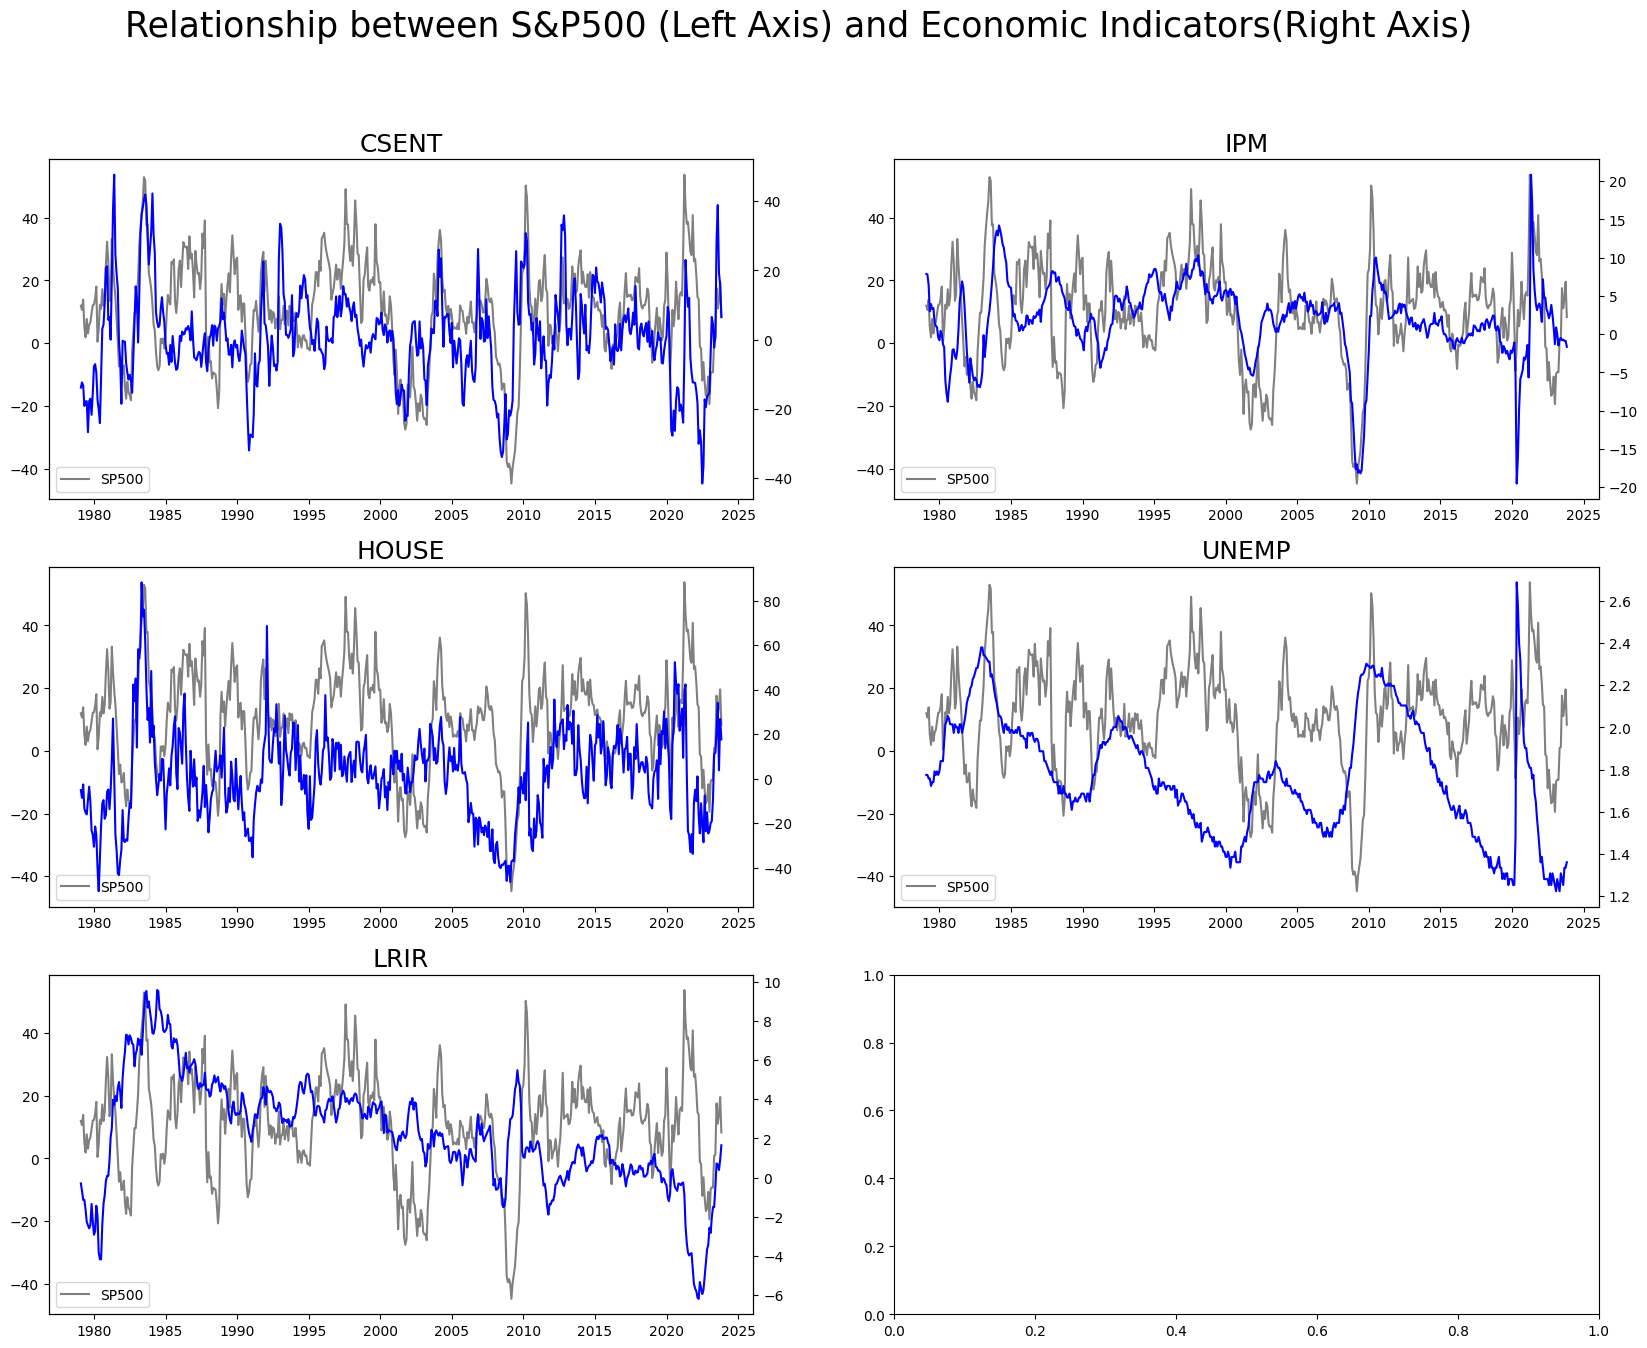

In [19]:
# Observing the relationships between S&P500 idex and economic indicators
rows, cols = 3, 2

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))
fig.suptitle('Relationship between S&P500 (Left Axis) and Economic Indicators(Right Axis)', fontsize=25)

for idx, d in enumerate(features[:-1]):
    i, j = idx // cols, idx % cols
    # plot two line charts
    ax[i][j].plot(pd.to_datetime(df['Date']), df['SP500'], color='grey', label='SP500')
    ax[i][j].twinx().plot(pd.to_datetime(df['Date']), df[d], color='blue', label=d)
    ax[i][j].set_title(f"{d}", fontsize=18)
    ax[i][j].legend()


### Stratified Histogram

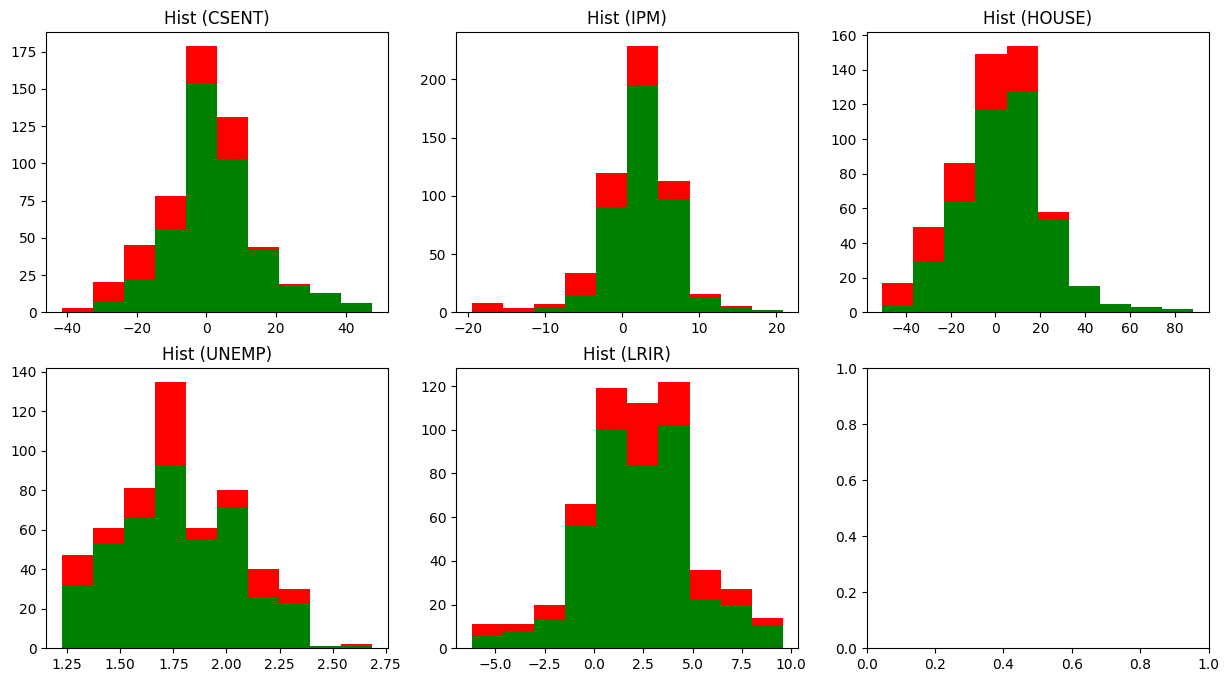

In [20]:
# Check histogram of each independent variable based on the ratio of categorical data.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for i, data in enumerate(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']):
    i1, i2 = i // 3, i % 3
    rise = df[df['SP500_Rise'] == 1.0][data]
    fall = df[df['SP500_Rise'] == 0.0][data]
    ax[i1][i2].hist([rise, fall], color=['green', 'red'], stacked=True)
    ax[i1][i2].set_title(f'Hist ({data})')


In [21]:
# Check the pairs (two independent variables) of the scatter plots based on the categorical data.

indicators = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']

corr_plot2 = sns.pairplot(df[indicators + ['SP500_Rise']], hue='SP500_Rise', 
                          plot_kws={'alpha': 0.5}, palette={1: "green", 0: "red"})

# Remove the existing legend
corr_plot2._legend.remove()

for i in range(len(indicators)):
    for j in range(len(indicators)):
        if i <= j:  # This condition identifies upper triangle and diagonal plots
            corr_plot2.axes[i, j].set_visible(False)

# Iterate again to set axis label font sizes (only for visible plots)
for ax in corr_plot2.axes.flatten():
    if ax.get_visible():
        # Set x-axis label
        ax.set_xlabel(ax.get_xlabel(), fontsize='large')
        # Set y-axis label
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')

plt.show()


C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


KeyboardInterrupt: 